## **Packages**

In [1]:
# packages
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from datetime import date, datetime
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
from hdfs import InsecureClient
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt #그래프 패키지 모듈 등록
%matplotlib inline 

In [2]:
# matplotlib 한글폰트 
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    rc('font', family='D2Coding')
       
# rc('font', family='NanumGothic') # 나눔폰트 사용시

In [4]:
# python과 mysql 연결을 위한 필요모듈 패키지
#!pip install pymysql

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 43 kB 3.2 MB/s             


In [3]:
import pymysql

/home/lab09/.local/lib/python3.6/site-packages/pymysql/_auth.py:8: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


## **DW DB계정 생성**

### 📍DB 계정 생성 (mysql)

In [ ]:
# mysql에서 진행

## mysql 실행
# service mysql start (docker) / sudo service mysql start (aws)
# mysql -u root (docker) / sudo mysql -u root -p (aws)

## user 생성
# mysql> create user bigMysql@'%' identified by 'bigMysql1234@';
# mysql> grant all privileges on *.* to bigMysql@'%' with grant option;

## 사용할 database 생성
# mysql> create database if not exists etlmysql;
# mysql> show databases;

### 📍 DB 계정/서버 정보 (JDBC)

In [4]:
JDBC = {
      'url':'jdbc:mysql://35.77.255.41:3306/etlmysql?character_set_server=utf8mb4&serverTimezone=Asia/Seoul'
     ,'props':{
      'user':'bigMysql',
      'password':'bigMysql1234@'   
      }
}

## **DW DB에 Data 저장**

### **1️⃣ 관광지 정보 데이터**
- /dw_data/travel_data_preprocessed.json

In [5]:
travel_data = spark.read.json('/dw_data/travel_data_preprocessed.json', encoding='utf-8')

In [11]:
travel_data.show(2)
travel_data.printSchema()

+-----+----------------------------------+--------+--------+-----------+------------+--------------------+----------+-------------+------------+-----------------------+---------+----------------+--------------------------+--------+--------+------+--------+---------------------------------+---------+---------------------------------+------+--------+----------+----------+
|index|                              개요|개장기간|공연시간|관광지 분류|관람소요시간|                명칭|      분류|     상세정보|      쉬는날|애완동물 동반 가능 여부| 우편번호|유모차 대여 여부|                  이용시간|이용시기|이용요금|입장료|전화번호|                             주소| 주차시설|                         주차요금|  지역|체험안내|행사시작일|행사종료일|
+-----+----------------------------------+--------+--------+-----------+------------+--------------------+----------+-------------+------------+-----------------------+---------+----------------+--------------------------+--------+--------+------+--------+---------------------------------+---------+---------------------------------+------+--------+--

In [16]:
JDBC

{'url': 'jdbc:mysql://35.77.255.41:3306/etlmysql?character_set_server=utf8mb4&serverTimezone=Asia/Seoul',
 'props': {'user': 'bigMysql', 'password': 'bigMysql1234@'}}

In [17]:
# write.mode('overwrite') = 기존 테이블 있으면 해당 테이블에 새로 저장되는 레코드로 덮어쓰기
# url = db주소 (JDBC['url'])
# table = 테이블명
# properties = 계정 등 연결 정보 (JDBC['props'])
travel_data.write.mode('overwrite').jdbc(url=JDBC['url'], table='OVERALL',properties=JDBC['props'])

### **2️⃣ 평점 데이터**
- /dw_data/tour_ratings.json

In [18]:
tour_ratings = spark.read.json('/dw_data/tour_ratings.json', encoding='utf-8')

In [19]:
tour_ratings.show(2)
tour_ratings.printSchema()

+-----+--------------------+----+
|index|                명칭|평점|
+-----+--------------------+----+
|    1|        (주)교보문고| 0.0|
|    2|1.21 무장공비 침투로| 5.6|
+-----+--------------------+----+
only showing top 2 rows

root
 |-- index: long (nullable = true)
 |-- 명칭: string (nullable = true)
 |-- 평점: double (nullable = true)



In [20]:
JDBC

{'url': 'jdbc:mysql://35.77.255.41:3306/etlmysql?character_set_server=utf8mb4&serverTimezone=Asia/Seoul',
 'props': {'user': 'bigMysql', 'password': 'bigMysql1234@'}}

In [21]:
# write.mode('overwrite') = 기존 테이블 있으면 해당 테이블에 새로 저장되는 레코드로 덮어쓰기
# url = db주소 (JDBC['url'])
# table = 테이블명
# properties = 계정 등 연결 정보 (JDBC['props'])
tour_ratings.write.mode('overwrite').jdbc(url=JDBC['url'], table='RATINGS',properties=JDBC['props'])

### **3️⃣ 관광지 키워드 데이터**
- /dw_data/tour_keywords.json

In [22]:
tour_keywords = spark.read.json('/dw_data/tour_keywords.json', encoding='utf-8')

In [23]:
tour_keywords.show(2)
tour_keywords.printSchema()

+-------------+-------------+-------------+--------------------+-----+
|Top_Keyword_1|Top_Keyword_2|Top_Keyword_3|   Tourist_Spot_Name|index|
+-------------+-------------+-------------+--------------------+-----+
|    adventure|       joyful|          art|        (주)교보문고|    1|
|    tradition|     cultural|    adventure|1.21 무장공비 침투로|    2|
+-------------+-------------+-------------+--------------------+-----+
only showing top 2 rows

root
 |-- Top_Keyword_1: string (nullable = true)
 |-- Top_Keyword_2: string (nullable = true)
 |-- Top_Keyword_3: string (nullable = true)
 |-- Tourist_Spot_Name: string (nullable = true)
 |-- index: long (nullable = true)



In [24]:
JDBC

{'url': 'jdbc:mysql://35.77.255.41:3306/etlmysql?character_set_server=utf8mb4&serverTimezone=Asia/Seoul',
 'props': {'user': 'bigMysql', 'password': 'bigMysql1234@'}}

In [25]:
# write.mode('overwrite') = 기존 테이블 있으면 해당 테이블에 새로 저장되는 레코드로 덮어쓰기
# url = db주소 (JDBC['url'])
# table = 테이블명
# properties = 계정 등 연결 정보 (JDBC['props'])
tour_keywords.write.mode('overwrite').jdbc(url=JDBC['url'], table='KEYWORDS',properties=JDBC['props'])

### **3️⃣ 관광지 이미지 경로 데이터**
- /dw_data/tour_image_path.csv

In [5]:
tour_imgpath = spark.read.csv('/dw_data/tour_image_path.csv', encoding='utf-8')

In [7]:
imgpath_pd = tour_imgpath.toPandas()
imgpath_pd.head(2)

,_c0,_c1,_c2,_c3
0,None,index1,name,image_path
1,0,1750,(구)인천일본제58은행지점,/home/lab09/tour_image/(구)인천일본제58은행지점_1.jpg


In [8]:
# 0행을 header 로 지정
new_header = imgpath_pd.iloc[0]
imgpath_pd = imgpath_pd[1:]
imgpath_pd.columns = new_header
imgpath_pd.head(2)

,NaN,index1,name,image_path
1,0,1750,(구)인천일본제58은행지점,/home/lab09/tour_image/(구)인천일본제58은행지점_1.jpg
2,1,1750,(구)인천일본제58은행지점,/home/lab09/tour_image/(구)인천일본제58은행지점_10.jpg


In [15]:
# NaN column 삭제
imgpath_pd = imgpath_pd[['index1', 'name', 'image_path']]

In [19]:
# index1 -> index 로 컬럼명 변경
imgpath_pd.rename(columns={'index1':'index'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
imgpath_pd.head(2)

,index,name,image_path
1,1750,(구)인천일본제58은행지점,/home/lab09/tour_image/(구)인천일본제58은행지점_1.jpg
2,1750,(구)인천일본제58은행지점,/home/lab09/tour_image/(구)인천일본제58은행지점_10.jpg


In [25]:
imgpath_pd.to_json('./tour_image_path.json', orient='records', lines=True)

## **✅ 확인**

In [9]:
# Table 잘 생성되었는지 mysql 에서 확인
# mysql > use etlmysql;
# mysql > show tables; 

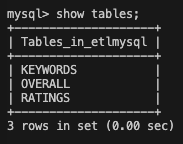